In [8]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## 1. Dataset for all images 

In [ ]:
class ODOCSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, mask_key='mask', image_ext='.jpg', mask_ext='.mat'):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.mask_key = mask_key
        self.image_ext = image_ext
        self.mask_ext = mask_ext
        image_files = [f for f in os.listdir(images_dir) if f.endswith(image_ext)]
        self.samples = []
        for img_file in image_files:
            img_id = os.path.splitext(img_file)[0]
            mask_file = img_id + mask_ext
            mask_path = os.path.join(masks_dir, mask_file)
            if os.path.isfile(mask_path):
                self.samples.append((os.path.join(images_dir, img_file), mask_path))
        print(f"Found {len(self.samples)} pairs.")
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        image_path, mask_path = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        mat = loadmat(mask_path)
        mask = mat[self.mask_key].astype(np.uint8)  # 0=bg, 1=OD, 2=OC
        
        if mask.shape != image.size[::-1]:
            mask = Image.fromarray(mask)
            mask = mask.resize(image.size, resample=Image.NEAREST)
            mask = np.array(mask)
        
        image = np.array(image).transpose(2,0,1) / 255.0
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.long)
        return image, mask

Unique values in mask: [0 1 2]


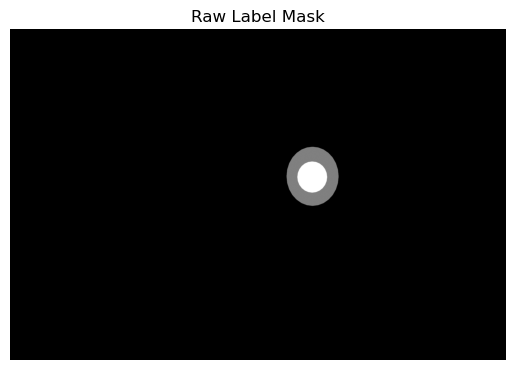

In [17]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

mat = scipy.io.loadmat('ORIGA/ORIGA/Semi-automatic-annotations/009.mat')
mask = mat['mask']


print("Unique values in mask:", np.unique(mask))


plt.imshow(mask, cmap='gray')
plt.title("Raw Label Mask")
plt.axis('off')
plt.show()

In [10]:
img_dir = 'ORIGA/ORIGA/roi_images'
mask_dir = 'ORIGA/ORIGA/Semi-automatic-annotations'

In [11]:
dataset = ODOCSegmentationDataset(img_dir, mask_dir)
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

Found 650 pairs.


## 4. Model: ResNet34 U-Net

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,   # train from scratch
    in_channels=3,
    classes=3
).to(device)

## 5. Loss and Optimizer

In [13]:
class_weights = torch.tensor([1.0, 30.0, 50.0], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 6. Training loop

In [14]:
num_epochs = 130
for epoch in range(num_epochs):
    model.train()
    losses = []
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(losses):.4f}")

Epoch 1/130, Loss: 0.6078
Epoch 2/130, Loss: 0.4925
Epoch 3/130, Loss: 0.4483
Epoch 4/130, Loss: 0.4247
Epoch 5/130, Loss: 0.4083
Epoch 6/130, Loss: 0.4098
Epoch 7/130, Loss: 0.3989
Epoch 8/130, Loss: 0.3789
Epoch 9/130, Loss: 0.3665
Epoch 10/130, Loss: 0.3987
Epoch 11/130, Loss: 0.3732
Epoch 12/130, Loss: 0.3495
Epoch 13/130, Loss: 0.3542
Epoch 14/130, Loss: 0.3534
Epoch 15/130, Loss: 0.3355
Epoch 16/130, Loss: 0.3404
Epoch 17/130, Loss: 0.3332
Epoch 18/130, Loss: 0.3267
Epoch 19/130, Loss: 0.3357
Epoch 20/130, Loss: 0.3176
Epoch 21/130, Loss: 0.3169
Epoch 22/130, Loss: 0.3171
Epoch 23/130, Loss: 0.3153
Epoch 24/130, Loss: 0.3130
Epoch 25/130, Loss: 0.3153
Epoch 26/130, Loss: 0.3131
Epoch 27/130, Loss: 0.3021
Epoch 28/130, Loss: 0.3048
Epoch 29/130, Loss: 0.2939
Epoch 30/130, Loss: 0.3017
Epoch 31/130, Loss: 0.2991
Epoch 32/130, Loss: 0.2907
Epoch 33/130, Loss: 0.2923
Epoch 34/130, Loss: 0.2840
Epoch 35/130, Loss: 0.2861
Epoch 36/130, Loss: 0.2997
Epoch 37/130, Loss: 0.2938
Epoch 38/1

## 7. Visualize prediction

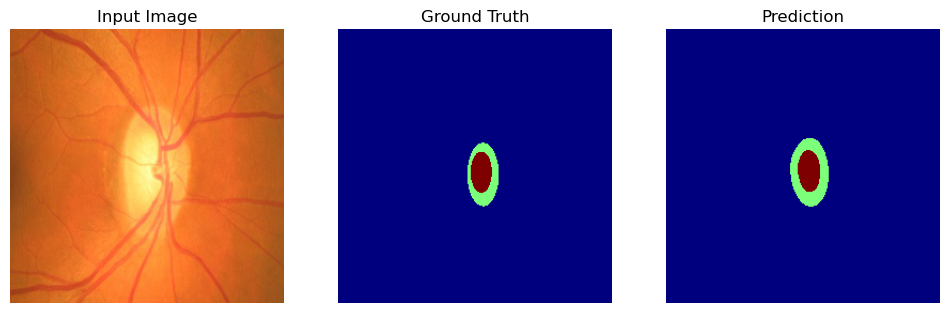

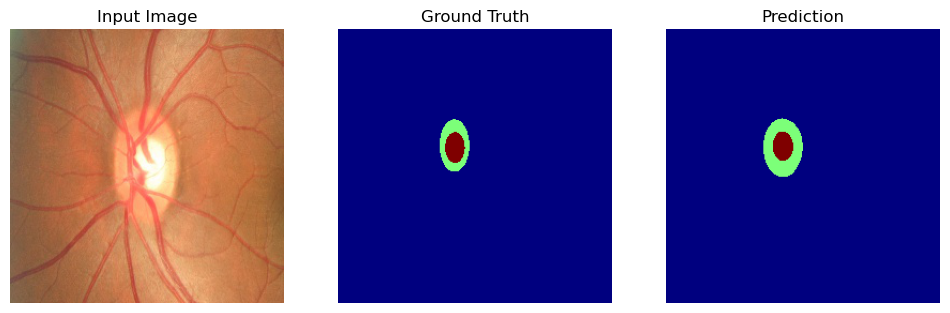

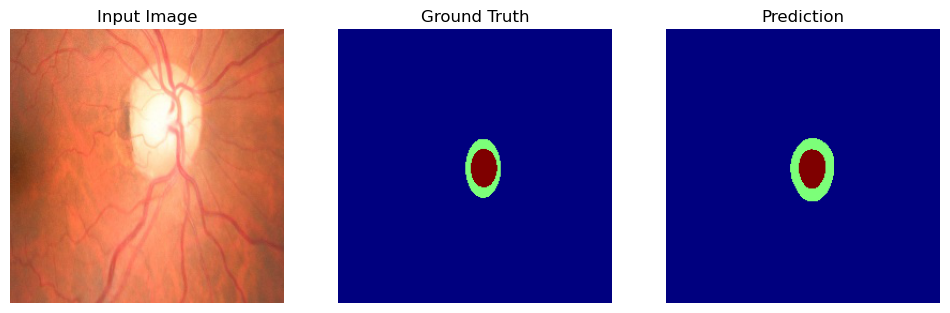

In [15]:
model.eval()
n_show = 3
with torch.no_grad():
    shown = 0
    for images, masks in loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu()
        images = images.cpu()
        masks = masks.cpu()
        for i in range(images.shape[0]):
            plt.figure(figsize=(12,4))
            plt.subplot(1,3,1)
            plt.imshow(images[i].permute(1,2,0))
            plt.title('Input Image')
            plt.axis('off')
            plt.subplot(1,3,2)
            plt.imshow(masks[i], cmap='jet', vmin=0, vmax=2)
            plt.title('Ground Truth')
            plt.axis('off')
            plt.subplot(1,3,3)
            plt.imshow(preds[i], cmap='jet', vmin=0, vmax=2)
            plt.title('Prediction')
            plt.axis('off')
            plt.show()
            shown += 1
            if shown >= n_show:
                break
        if shown >= n_show:
            break

In [29]:
os.makedirs('masks', exist_ok=True)
palette = [
    0, 0, 0,      
    255, 0, 0,   
    0, 255, 0,    
] + [0, 0, 0] * 253  

def save_color_mask(mask, img_id):
  
    mask_img = Image.fromarray(mask.astype(np.uint8), mode='P')
    mask_img.putpalette(palette)
    mask_img.save(f'masks/{img_id}.png')

In [28]:
for batch_idx, (images, masks) in enumerate(loader):
    images = images.to(device)
    outputs = model(images)
    preds = outputs.argmax(1).cpu().numpy()
    for i in range(images.shape[0]):
        img_path, _ = dataset.samples[batch_idx * loader.batch_size + i]
        img_id = os.path.splitext(os.path.basename(img_path))[0]
        save_color_mask(preds[i], img_id)